## Introduction to Statistical API

In the Process API examples, we have seen how to obtain satellite imagery. [Statistical API](https://docs.sentinel-hub.com/api/latest/api/statistical/) can be used in a very similar way. The main difference is that the results of Statistical API are aggregated statistical values of satellite data instead of entire images. In many use cases, such values are all that we need. By using Statistical API we can avoid downloading and processing large amounts of satellite data.

All general rules for building evalscripts apply. However, there are some specifics when using evalscripts with the Statistical API:

- The `evaluatePixel()` function must, in addition to other output, always return a `dataMask` output. This output defines which pixels are excluded from calculations. For more details and an example, see [here](https://docs.sentinel-hub.com/api/latest/api/statistical/#exclude-pixels-from-calculations-datamask-output).
- The default value of sampleType is `FLOAT32`.
- The output.bands parameter in the setup() function can be an array. This makes it possible to specify custom names for the output bands and different output `dataMask` for different outputs, see this [example](https://docs.sentinel-hub.com/api/latest/api/statistical/examples/#multiple-outputs-with-different-datamasks-multi-band-output-with-custom-bands-names-and-different-histogram-types).

### Python Library Imports

In [ ]:
!pip install contextily numpy pandas geopandas sentinelhub

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
   --- ------------------------------------ 1.0/12.8 MB 7.2 MB/s eta 0:00:02
   ---------- ----------------------------- 3.4/12.8 MB 9.2 MB/s eta 0:00:02
   ------------------ --------------------- 5.8/12.8 MB 10.1 MB/s eta 0:00:01
   -------------------------- ------------- 8.4/12.8 MB 10.4 MB/s eta 0:00:01
   --------------------------------- ------ 10.7/12.8 MB 10.7 MB/s eta 0:00:01
   ---------------------------------------  12.6/12.8 MB 10.7 MB/s eta 0:00:01
   ---------------------------------------- 12.8/12.8 MB 10.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------- ----------------------------- 2.1/8.1 MB 10.7 MB/s eta 0:00:01
   ----------------------- ---------------- 4.7/8.1 MB 11.0 MB/s eta 0:00:01
   -------------------------------- ------- 6.6/8.1 MB 10.3 MB/s eta 0:00:01
   --


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: C:\Users\MdRakibTrofder\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [6]:
# Utilities
import getpass
import warnings
from typing import (
    Optional,
    Tuple,
    Any
)
warnings.filterwarnings('ignore', category=UserWarning)  # Suppress specific warnings

# Data Manipulation
import pandas as pd
import geopandas as gpd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import contextily as cx

# Sentinel Hub
from sentinelhub import (
    SHConfig,
    DataCollection,
    SentinelHubStatistical,
    SentinelHubStatisticalDownloadClient,
    CRS,
    Geometry,
    parse_time
)

C:\Users\MdRakibTrofder\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Helper Functions

In [10]:
# Helper Utility Functions

def plot_image(
    image: np.ndarray,
    factor: float = 1.0,
    clip_range: Optional[Tuple[float, float]] = None,
    **kwargs: Any
) -> None:
    """Utility function for plotting RGB images."""
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range), **kwargs)
    else:
        ax.imshow(image * factor, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])

# define functions to extract statistics for all acquisition dates
def extract_stats(date, stat_data):
    d = {}
    for key, value in stat_data['outputs'].items():
        stats = value['bands']['B0']['stats']
        if stats['sampleCount']==stats['noDataCount']:
            continue
        else:
            d['date'] = [date]
            for stat_name, stat_value in stats.items():
                if (stat_name=='sampleCount' or stat_name=='noDataCount'):
                    continue
                else:
                    d[f'{key}_{stat_name}'] = [stat_value]
    return pd.DataFrame(d)

def read_acquisitions_stats(stat_data):
    df_li = []
    for aq in stat_data:
        date = aq['interval']['from'][:10]
        df_li.append(extract_stats(date, aq))
    return pd.concat(df_li)

def stats_to_df(stats_data):
    """Transform Statistical API response into a pandas.DataFrame"""
    df_data = []

    for single_data in stats_data["data"]:
        df_entry = {}
        is_valid_entry = True

        df_entry["interval_from"] = parse_time(single_data["interval"]["from"]).date()
        df_entry["interval_to"] = parse_time(single_data["interval"]["to"]).date()

        for output_name, output_data in single_data["outputs"].items():
            for band_name, band_values in output_data["bands"].items():
                band_stats = band_values["stats"]
                if band_stats["sampleCount"] == band_stats["noDataCount"]:
                    is_valid_entry = False
                    break

                for stat_name, value in band_stats.items():
                    col_name = f"{output_name}_{band_name}_{stat_name}"
                    if stat_name == "percentiles":
                        for perc, perc_val in value.items():
                            perc_col_name = f"{col_name}_{perc}"
                            df_entry[perc_col_name] = perc_val
                    else:
                        df_entry[col_name] = value

        if is_valid_entry:
            df_data.append(df_entry)

    return pd.DataFrame(df_data)

### Credentials

Credentials for Sentinel Hub services (client_id & client_secret) can be obtained in your [Dashboard](https://apps.sentinel-hub.com/dashboard/#/). In the User Settings you can create a new OAuth Client to generate these credentials. For more detailed instructions, visit the relevant documentation page.

Now that you have your `client_id` & `client_secret`, it is recommended to configure a new profile in your Sentinel Hub Python package. Instructions on how to configure your Sentinel Hub Python package can be found [here](https://sentinelhub-py.readthedocs.io/en/latest/configure.html). This is useful as changes to the the `config` class are usually only temporary in your notebook and by saving the configuration to your profile you won't need to generate new credentials or overwrite/change the default profile each time you rerun or write a new Jupyter Notebook.

If you are a first time user of the Sentinel Hub Python package, you should create a profile so you don't need to create new credentials each time you open up Jupyter Lab. You can do this in the following cell:

In [11]:
# Pass Sentinel Hub credentials to SHConfig
config = SHConfig(
    sh_client_id='943e31e9-a4eb-49cf-b2e1-c0932e8e5e88',
    sh_client_secret='0Dlg7u5xeUcS1luMcSFd4ZVrI2jywAFd'
)

### Creating a field of interest

Firstly, we will define some fields of interest in France for the first few examples. Our fields of interest and the time period we are using coincides with the temporal and spatial extent of the [PlanetScope](https://docs.planet.com/data/imagery/planetscope/sandbox/) dataset within the Planet Sandbox Data Collection. We will use the [Sentinel-2 L2A](https://docs.sentinel-hub.com/api/latest/data/sentinel-2-l2a/) data collection in the first examples though.

In [12]:
fields="""{
"type": "FeatureCollection",
"name": "eswatini_fields",
"crs": { "type": "name", "properties": { "name": "urn:ogc:def:crs:OGC:1.3:CRS84" } },
"features": [
{ "type": "Feature", "properties": { "id": 1 }, "geometry": {"type":"Polygon","coordinates":[[[16.744666,-19.013074],[16.744623,-19.017335],[16.755781,-19.017335],[16.755781,-19.013399],[16.744666,-19.013074]]]} },
{ "type": "Feature", "properties": { "id": 2 }, "geometry": {"type":"MultiPolygon","coordinates":[[[[16.744666,-19.013074],[16.744623,-19.017335],[16.755781,-19.017335],[16.755781,-19.013399],[16.744666,-19.013074]]],[[[16.734452,-19.004795],[16.732221,-19.00934],[16.737156,-19.012141],[16.742606,-19.004916],[16.734452,-19.004795]]]]} },
{ "type": "Feature", "properties": { "id": 3 }, "geometry": {"type":"MultiPolygon","coordinates":[[[[16.744666,-19.013074],[16.744623,-19.017335],[16.755781,-19.017335],[16.755781,-19.013399],[16.744666,-19.013074]]],[[[16.734452,-19.004795],[16.732221,-19.00934],[16.737156,-19.012141],[16.742606,-19.004916],[16.734452,-19.004795]]],[[[16.727972,-19.023585],[16.725655,-19.030321],[16.74192,-19.029997],[16.743851,-19.024762],[16.735053,-19.023707],[16.731405,-19.025208],[16.727972,-19.023585]]]]} }
]
}
"""

## 1. How to create an NDVI time series for a field of interest

### The Evalscript

In this evalscript, we are calculating NDVI. Let's remind ourselves that evalscripts operate slightly differently with Statistical API:

- The `evaluatePixel()` function must, in addition to other output, always return a `dataMask` output. This output defines which pixels are excluded from calculations. For more details and an example, see [here](https://docs.sentinel-hub.com/api/latest/api/statistical/#exclude-pixels-from-calculations-datamask-output).
- The default value of sampleType is `FLOAT32`.
- The output.bands parameter in the setup() function can be an array. This makes it possible to specify custom names for the output bands and different output `dataMask` for different outputs, see this [example](https://docs.sentinel-hub.com/api/latest/api/statistical/examples/#multiple-outputs-with-different-datamasks-multi-band-output-with-custom-bands-names-and-different-histogram-types).

In [25]:
evalscript = """
//VERSION=3
function setup() {
  return {
    input: [{
      bands: [
        "B04",
        "B08",
        "dataMask"
      ]
    }],
    output: [
      {
        id: "ndvi",
        bands: 1
      },
      {
        id: "dataMask",
        bands: 1
      }]
  };
}

function evaluatePixel(samples) {
    let index = (samples.B08 - samples.B04) / (samples.B08+ samples.B04);
    return {
        ndvi: [index],
        dataMask: [samples.dataMask],
    };
}
"""

### The Request Body

Now we have defined the evalscript and the two fields of interest, we can build the first Statistical API Request, before returning the response for the first field. In this request, as part of the payload we define some input parameters:
- `time_interval` this defines the time range of our request.
- `aggregation_interval` this defines the length of time each interval is. In this case, the interval is 10 days. The aggregation intervals should be at least one day long (e.g. "P5D", "P30D"). You can only use period OR time designator not both. 

**NOTE:**
If `time_interval` is not divisible by an aggregationInterval, the last ("not full") time interval will be dismissed by default (SKIP option). The user can instead set the lastIntervalBehavior to SHORTEN (shortens the last interval so that it ends at the end of the provided time range) or EXTEND (extends the last interval over the end of the provided time range so that all the intervals are of equal duration).

In [26]:
fields_gdf = gpd.read_file(fields)

geometry = Geometry(geometry=fields_gdf.geometry.iloc[0], crs=CRS.WGS84)

request = SentinelHubStatistical(
    aggregation=SentinelHubStatistical.aggregation(
        evalscript=evalscript,
        time_interval=('2023-01-01T00:00:00Z', '2023-12-31T23:59:59Z'),
        aggregation_interval='P5D',
        resolution=(0.0001,0.0001),        
    ),
    input_data=[
        SentinelHubStatistical.input_data(
            DataCollection.SENTINEL2_L2A,
      ),
    ],
    geometry=geometry,
    config=config
)

response1 = request.get_data()
#response1 # try uncommenting this line to see what the raw JSON response looks like. 

### Manipulation and Visualisation of our Output

However, as it is clear to see, our response is not that useful in `json` format. It's difficult to read from a human perspective. So, let's transform it into a `pandas` dataframe. To help us achieve this, let's call some helper functions. 

In [28]:
result_df1 = read_acquisitions_stats(response1[0]['data'])
result_df1

,date,ndvi_min,ndvi_max,ndvi_mean,ndvi_stDev
0,2023-01-01,0.134146,0.359257,0.234040,0.027924
0,2023-01-06,0.159763,0.305449,0.233284,0.017526
0,2023-01-11,0.161179,0.318644,0.239122,0.019977
0,2023-01-16,0.000000,0.015492,0.007783,0.002122
0,2023-01-21,0.191332,0.442296,0.329594,0.030246
...,...,...,...,...,...
0,2023-12-02,0.104167,0.195730,0.150793,0.013540
0,2023-12-07,-0.115923,0.195920,0.018587,0.034731
0,2023-12-12,0.109774,0.227077,0.162056,0.017650
0,2023-12-17,-0.088634,0.326350,0.166291,0.052512


We can take this another step further, and display the data in a time series using the Matplotlib python library:

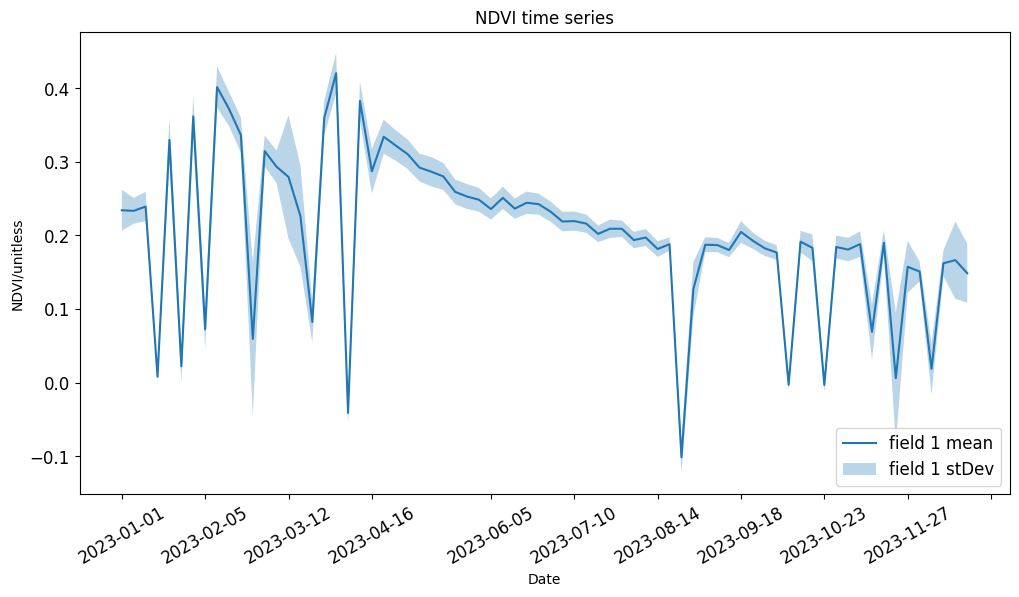

In [29]:
fig_stat, ax_stat = plt.subplots(1, 1, figsize=(12, 6))

# Extract data
t1 = result_df1['date']
ndvi_mean_field1 = result_df1['ndvi_mean']
ndvi_std_field1 = result_df1['ndvi_stDev']

# Plot mean and standard deviation
ax_stat.plot(t1, ndvi_mean_field1, label='field 1 mean')
ax_stat.fill_between(t1, ndvi_mean_field1 - ndvi_std_field1, ndvi_mean_field1 + ndvi_std_field1, alpha=0.3, label='field 1 stDev')

# Set tick parameters
ax_stat.tick_params(axis='x', labelrotation=30, labelsize=12)
ax_stat.tick_params(axis='y', labelsize=12)

# Reduce number of x-tick labels
ax_stat.xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=20))

# Set labels and title
ax_stat.set(xlabel='Date', ylabel='NDVI/unitless', title='NDVI time series')

# Set legend
ax_stat.legend(loc='lower right', prop={'size': 12});